'Done'

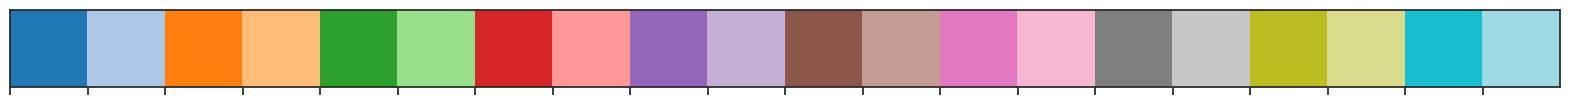

In [1]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd, json, numpy as np
import pickle, pymysql#; pymysql.install_as_MySQLdb() from sqlalchemy import create_engine
from html import unescape
from unidecode import unidecode
from tqdm import tqdm 
import itertools, re
import tauSearch as tau
import time, matplotlib.pyplot as plt,seaborn as sns 
from matplotlib.colors import ListedColormap
import mysql.connector as sql
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis, pyLDAvis.lda_model; pyLDAvis.enable_notebook()

sns.set(style="ticks", color_codes=True)
sns.palplot(sns.color_palette("tab20", 20)) # https://www.geeksforgeeks.org/seaborn-color-palette/
SEED = 0
'Done'

In [2]:
#db, usr, pas, host = 'rpi', 'root', '', 'localhost'
#conn = sql.connect(db=db,user=usr,host=host,password=pas,use_unicode=True, auth_plugin= "mysql_native_password")
#df = pd.read_sql('SELECT * FROM religion', con=conn)
fData = 'data/joined-text-religion.csv'
df = pd.read_csv(fData)
df['logTotal'] = np.log(df['totalResults'])
print(df.shape)
df.head()

(4368, 8)


,date,qryID,entity,site,totalResults,text,text_cleaned,logTotal
0,2010-01-01,24da1eff83f8cfe4d1977148df77e834,islam,facebook,766,Kalam Guru - PELAJARAN DARI GUS DUR Oleh: Ahma...,kalam pelajaran tohari naik bersama tidur memi...,6.641182
1,2010-01-01,4062e31abb113b1c66065ca5b9a93f81,kristen,facebook,292,IMAN Katolik menjawab 18 Jan 2010 ... Apakah y...,iman menjawab ajaran gereja gereja mengajarkan...,5.676754
2,2010-01-01,f34f2441f74132bfb8317f097f86adf7,hindu,facebook,9,Museum Anjuk Ladang - Facebook 18 Jan 2010 ......,museum anjuk ladang yoni lingga bangunan ber...,2.197225
3,2010-01-01,9bc03155ce36db2e0ce977e07bef0bf5,buddha,facebook,6,Kisah Para Dewa dan Ajaran Tao - Mengenai Inst...,kisah dewa ajaran mengenai institusi caici aga...,1.791759
4,2010-01-01,47bda847b2e12d27158e99ad076ca5a4,islam,twitter,6,NaN,NaN,1.791759


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          4368 non-null   object 
 1   qryID         4368 non-null   object 
 2   entity        4368 non-null   object 
 3   site          4368 non-null   object 
 4   totalResults  4368 non-null   int64  
 5   text          3356 non-null   object 
 6   text_cleaned  3356 non-null   object 
 7   logTotal      4368 non-null   float64
dtypes: float64(1), int64(1), object(6)
memory usage: 273.1+ KB


In [4]:
df = df.set_index(['date'])
df.head()

,qryID,entity,site,totalResults,text,text_cleaned,logTotal
date,,,,,,,
2010-01-01,24da1eff83f8cfe4d1977148df77e834,islam,facebook,766,Kalam Guru - PELAJARAN DARI GUS DUR Oleh: Ahma...,kalam pelajaran tohari naik bersama tidur memi...,6.641182
2010-01-01,4062e31abb113b1c66065ca5b9a93f81,kristen,facebook,292,IMAN Katolik menjawab 18 Jan 2010 ... Apakah y...,iman menjawab ajaran gereja gereja mengajarkan...,5.676754
2010-01-01,f34f2441f74132bfb8317f097f86adf7,hindu,facebook,9,Museum Anjuk Ladang - Facebook 18 Jan 2010 ......,museum anjuk ladang yoni lingga bangunan ber...,2.197225
2010-01-01,9bc03155ce36db2e0ce977e07bef0bf5,buddha,facebook,6,Kisah Para Dewa dan Ajaran Tao - Mengenai Inst...,kisah dewa ajaran mengenai institusi caici aga...,1.791759
2010-01-01,47bda847b2e12d27158e99ad076ca5a4,islam,twitter,6,NaN,NaN,1.791759


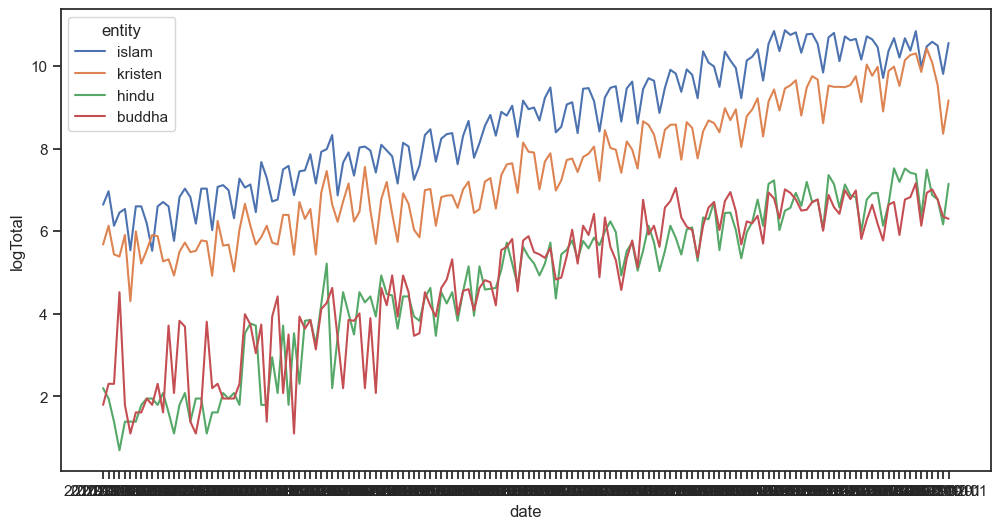

In [5]:
fb = df.loc[df['site'].isin(['facebook'])]
plt.figure(figsize=(12, 6))
p = sns.lineplot(data=fb, x="date", y="logTotal", hue="entity")

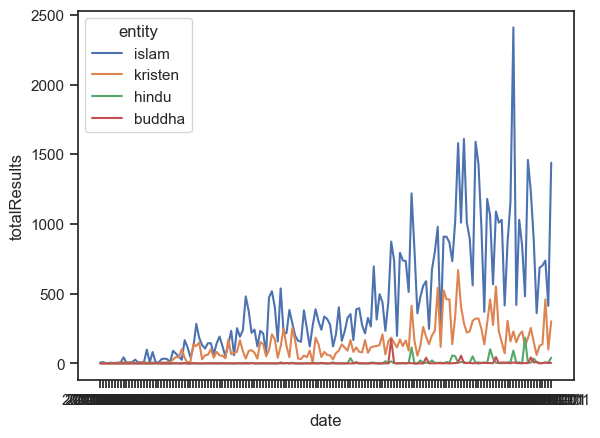

In [6]:
tw = df.loc[df['site'].isin(['twitter'])]
#plt.figure(figsize=(12, 6))
p = sns.lineplot(data=tw, x="date", y="totalResults", hue="entity")

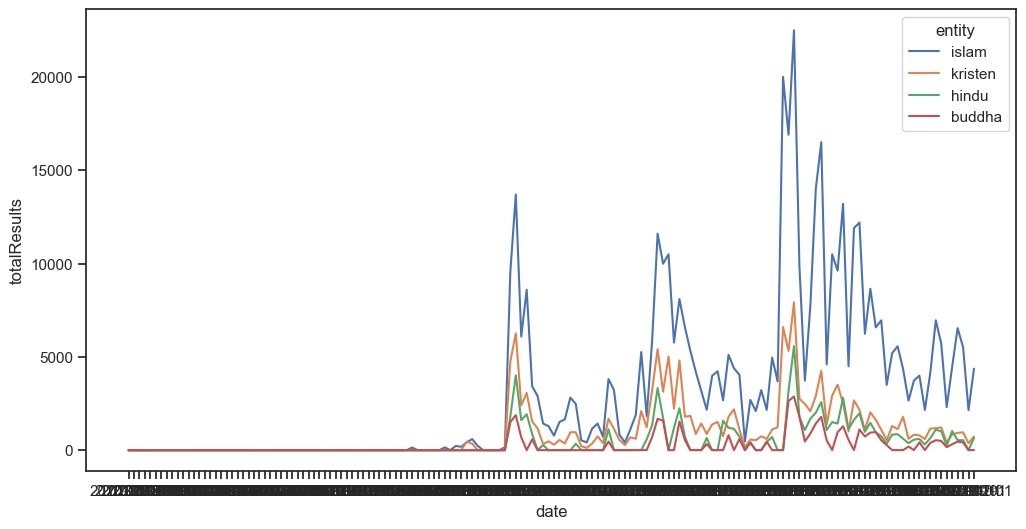

In [7]:
ig = df.loc[df['site'].isin(['instagram'])]
plt.figure(figsize=(12, 6))

p = sns.lineplot(data=ig, x="date", y="totalResults", hue="entity")

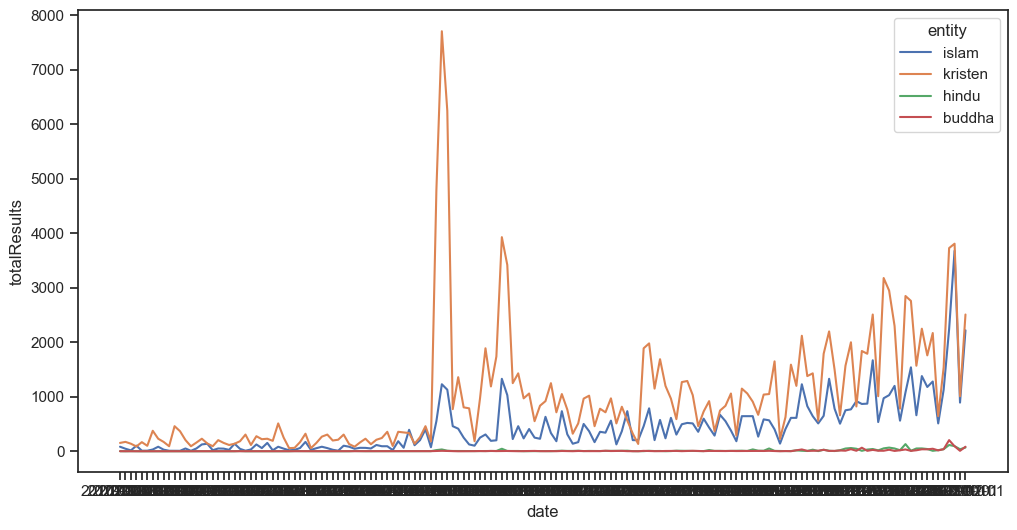

In [8]:
li = df.loc[df['site'].isin(['linkedin'])]
plt.figure(figsize=(12, 6))

p = sns.lineplot(data=li, x="date", y="totalResults", hue="entity")

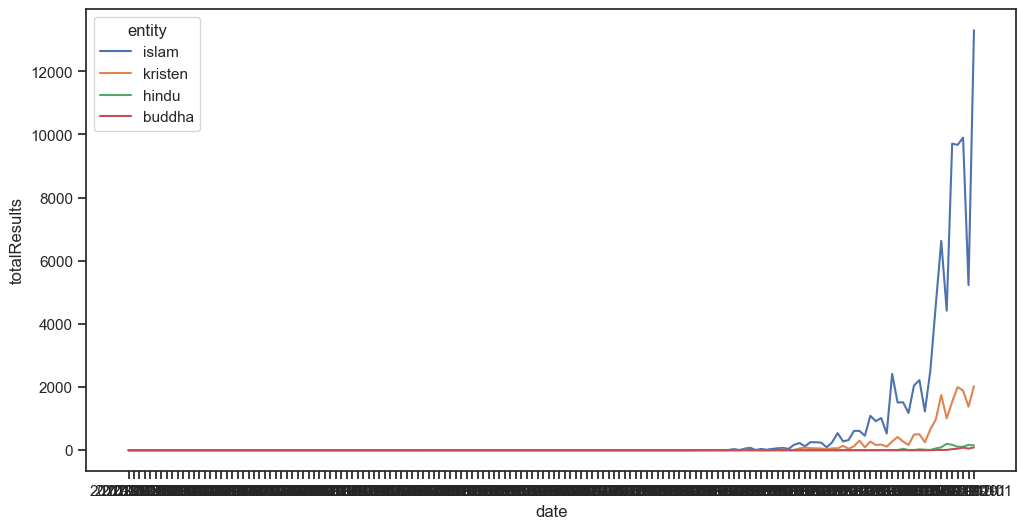

In [9]:
tk = df.loc[df['site'].isin(['tiktok'])]
plt.figure(figsize=(12, 6))

p = sns.lineplot(data=tk, x="date", y="totalResults", hue="entity")

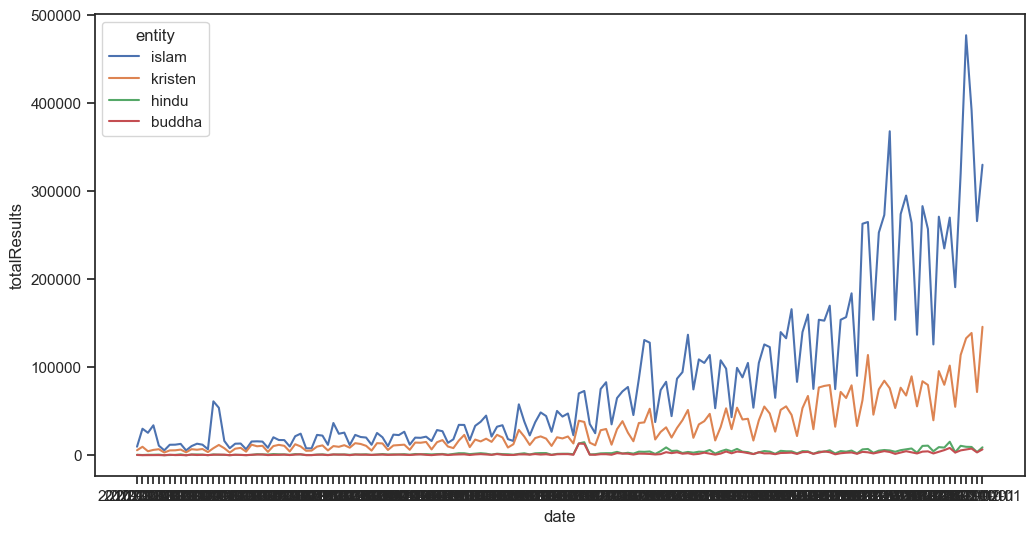

In [10]:
web = df.loc[df['site'].isin(['web'])]
plt.figure(figsize=(12, 6))

p = sns.lineplot(data=web, x="date", y="totalResults", hue="entity")

In [11]:
vectorizer = CountVectorizer(binary = False, lowercase=True)
data = df[df["entity"].isin(["islam"])]
data.dropna(inplace=True)
vsm = vectorizer.fit_transform(data['text_cleaned'])
print(vsm.shape)
lda = LDA(n_components=3, learning_method='batch', random_state=0).fit(vsm)   
pyLDAvis.lda_model.prepare(lda, vsm, vectorizer)  

(958, 56242)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.036248  0.072584       1        1  50.766725
0     -0.098367 -0.053231       2        1  34.053073
1      0.134615 -0.019353       3        1  15.180201, topic_info=               Term          Freq         Total Category  logprob  loglift
29156        maulid   5787.000000   5787.000000  Default  30.0000  30.0000
34268          nabi  20178.000000  20178.000000  Default  29.0000  29.0000
45531       selamat   4089.000000   4089.000000  Default  28.0000  28.0000
30153  memperingati   2521.000000   2521.000000  Default  27.0000  27.0000
651           agama  18307.000000  18307.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
53263          umat    687.743546   9305.692622   Topic3  -5.0752  -0.7198
49888         tahun    380.444426   2253.872696   Topic3  -5.6672   0.1061
45663       seluruh    295.083864   1167.260341   Topic3  -5.9213   0.5100
20969        jilbab    388.654313  11289.786640   Topic3  -5.6459  -1.4838
31523       menjadi    278.527323   1753.119319   Topic3  -5.9791   0.0455

[272 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
208        1  0.987423  abstrak
208        3  0.012992  abstrak
556        3  0.991608    aespa
651        1  0.629408    agama
651        2  0.209584    agama
...      ...       ...      ...
55289      2  0.893703    yahya
55289      3  0.021279    yahya
55671      2  0.992730    yufid
55730      3  0.952225     yuni
55835      2  0.992103     zaen

[454 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [12]:
vectorizer = CountVectorizer(binary = False, lowercase=True)
data = df[df["entity"].isin(["kristen"])]
data.dropna(inplace=True)
vsm = vectorizer.fit_transform(data['text_cleaned'])
print(vsm.shape)
lda = LDA(n_components=3, learning_method='batch', random_state=0).fit(vsm)   
pyLDAvis.lda_model.prepare(lda, vsm, vectorizer)  

(936, 46782)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.111985 -0.064197       1        1  52.943305
1     -0.109333  0.064712       2        1  38.945550
0      0.221318 -0.000515       3        1   8.111145, topic_info=              Term         Freq         Total Category  logprob  loglift
44491  universitas  5291.000000   5291.000000  Default  30.0000  30.0000
30554  parahyangan  1905.000000   1905.000000  Default  29.0000  29.0000
16858         jaya  1804.000000   1804.000000  Default  28.0000  28.0000
20675      koneksi  1284.000000   1284.000000  Default  27.0000  27.0000
16832         jawa  1529.000000   1529.000000  Default  26.0000  26.0000
...            ...          ...           ...      ...      ...      ...
18906     kegiatan   150.135830    743.287655   Topic3  -5.8530   0.9124
12762       gereja   595.309854  44141.968748   Topic3  -4.4755  -1.7942
30834       paskah   167.102374   5197.541323   Topic3  -5.7460  -0.9254
37953      selamat   136.631582   3340.813819   Topic3  -5.9473  -0.6848
41448        tahun   132.283380   2792.669189   Topic3  -5.9796  -0.5379

[268 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
424        1  0.201175      agama
424        2  0.778975      agama
424        3  0.019822      agama
622        1  0.306013     ajaran
622        2  0.693866     ajaran
...      ...       ...        ...
45646      3  0.697936     wijaya
45661      2  0.998852  wikipedia
46242      1  0.757218      yesus
46242      2  0.241004      yesus
46242      3  0.001837      yesus

[436 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [13]:
vectorizer = CountVectorizer(binary = False, lowercase=True)
data = df[df["entity"].isin(["hindu"])]
data.dropna(inplace=True)
vsm = vectorizer.fit_transform(data['text_cleaned'])
print(vsm.shape)
lda = LDA(n_components=2, learning_method='batch', random_state=0).fit(vsm)   
pyLDAvis.lda_model.prepare(lda, vsm, vectorizer)  

(753, 36525)


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.113565  0.0       1        1  76.710405
0     -0.113565  0.0       2        1  23.289595, topic_info=           Term         Freq         Total Category  logprob  loglift
22473     nyepi  6094.000000   6094.000000  Default  30.0000  30.0000
29536   selamat  4653.000000   4653.000000  Default  29.0000  29.0000
32394     tahun  3106.000000   3106.000000  Default  28.0000  28.0000
9628   galungan  3980.000000   3980.000000  Default  27.0000  27.0000
2686       baru  1983.000000   1983.000000  Default  26.0000  26.0000
...         ...          ...           ...      ...      ...      ...
11474     hyang   432.553326   2699.680140   Topic2  -5.4245  -0.3740
35722     widhi   407.806366   2482.393459   Topic2  -5.4834  -0.3490
4009      besar   243.839897    638.200553   Topic2  -5.9977   0.4950
35527      wasa   278.369928   1228.459520   Topic2  -5.8653  -0.0274
338       agama   439.638123  17034.157364   Topic2  -5.4083  -2.1999

[186 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
160        1  0.954420       adat
160        2  0.045309       adat
338        1  0.974219      agama
338        2  0.025830      agama
427        2  0.922744      ahass
...      ...       ...        ...
35722      1  0.835887      widhi
35722      2  0.164358      widhi
35795      1  0.996573  wikipedia
36079      1  0.987680     yadnya
36079      2  0.011735     yadnya

[269 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [14]:
vectorizer = CountVectorizer(binary = False, lowercase=True)
data = df[df["entity"].isin(["buddha"])]
data.dropna(inplace=True)
vsm = vectorizer.fit_transform(data['text_cleaned'])
print(vsm.shape)
lda = LDA(n_components=2, learning_method='batch', random_state=0).fit(vsm)   
pyLDAvis.lda_model.prepare(lda, vsm, vectorizer)  

(709, 31247)


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.133892  0.0       1        1  87.056544
0     -0.133892  0.0       2        1  12.943456, topic_info=            Term         Freq        Total Category  logprob  loglift
30308     waisak  4778.000000  4778.000000  Default  30.0000  30.0000
25236    selamat  2737.000000  2737.000000  Default  29.0000  29.0000
25394     semoga  1299.000000  1299.000000  Default  28.0000  28.0000
25409      semua  1308.000000  1308.000000  Default  27.0000  27.0000
17867  merayakan   655.000000   655.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
23697   renungan   203.011384  2942.787217   Topic2  -5.4843  -0.6293
11414       juni   128.905611   500.148091   Topic2  -5.9385   0.6888
9645       hidup   138.007318   745.948031   Topic2  -5.8703   0.3572
27633      tahun   142.404889  1580.333326   Topic2  -5.8389  -0.3621
11993      kasih   121.187464   422.066419   Topic2  -6.0003   0.7968

[166 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
12         1  0.997869       abad
277        1  0.994701      agama
277        2  0.005317      agama
363        2  0.921280      ahass
397        2  0.983223      aidin
...      ...       ...        ...
30534      1  0.224099      wesak
30534      2  0.769731      wesak
30604      1  0.999375  wikipedia
30655      1  0.090630    wirawan
30655      2  0.996927    wirawan

[232 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])